In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31) #dt.datetime(2019,6,30)

In [3]:
# Parameters
modSourceDir = "/results/SalishSea/nowcast-green.201812/"
modver = "201812"
Chl_N = 1.8


In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [6]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [7]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [8]:
data['diatoms']=data['Diatoms-1']+data['Diatoms-2']

In [9]:
def logt(x):
    return np.log10(x+.001)

In [10]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [11]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

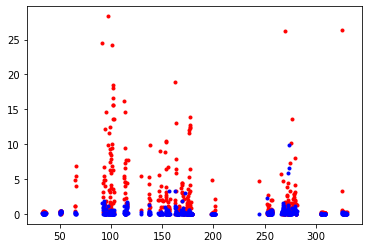

In [12]:
plt.plot(data['yd'],data['Diatoms-1'],'r.')
plt.plot(data['yd'],data['Diatoms-2'],'b.')

### Which HPLC groups are significant?

Text(0, 0.5, 'Count')

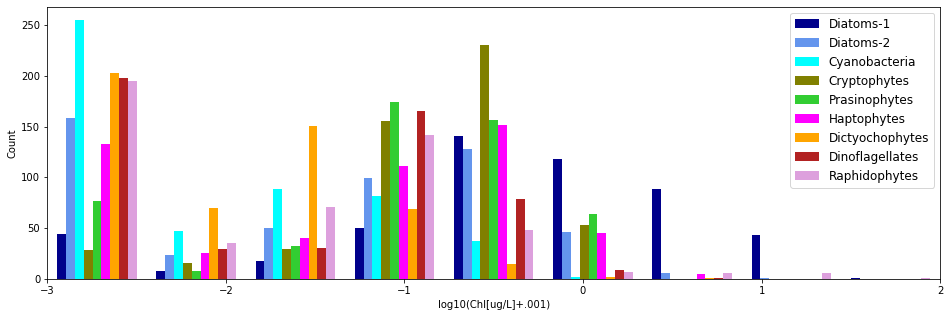

In [13]:
fig,ax=plt.subplots(1,1,figsize=(16,5))
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
x=np.array([logt(data[el]) for el in hplclist]).T
cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
bins=np.linspace(-3,2,10)
ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
ax.legend(prop={'size': 12});
ax.set_xlim(-3,2)
ax.set_xlabel('log10(Chl[ug/L]+.001)')
ax.set_ylabel('Count')

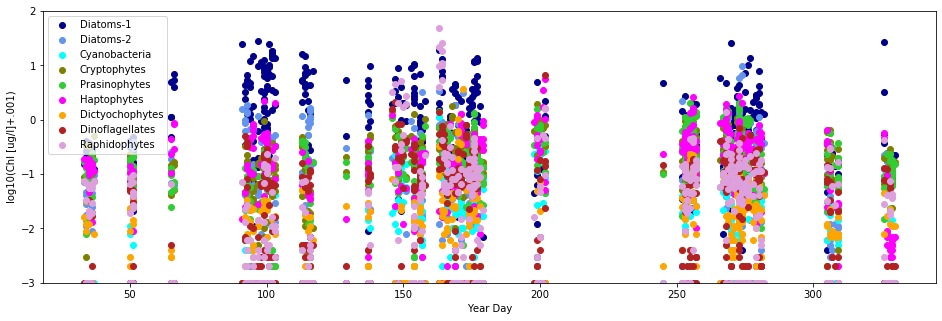

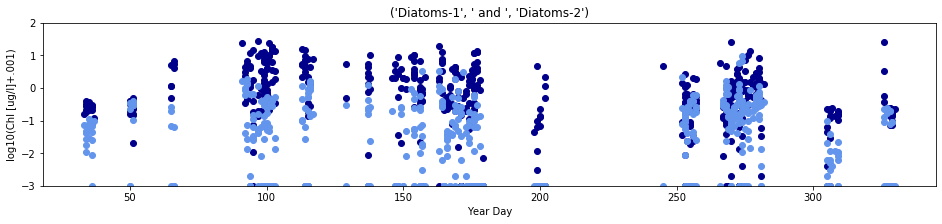

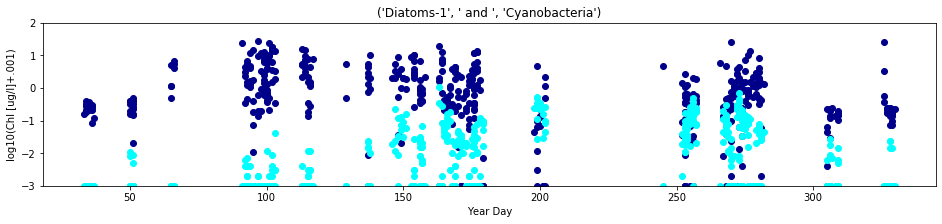

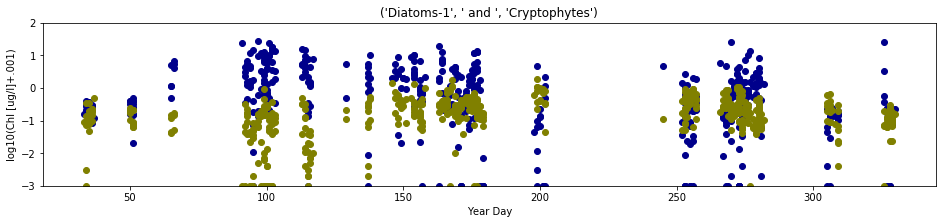

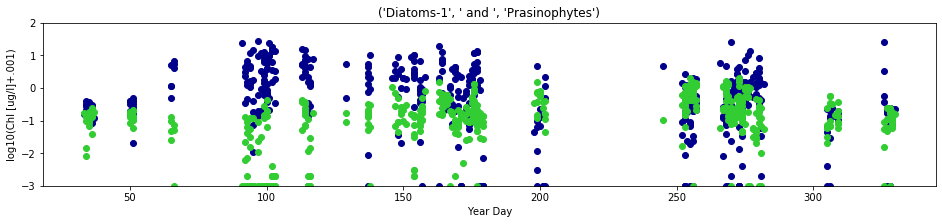

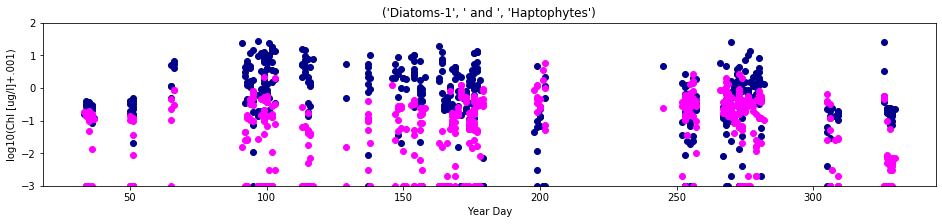

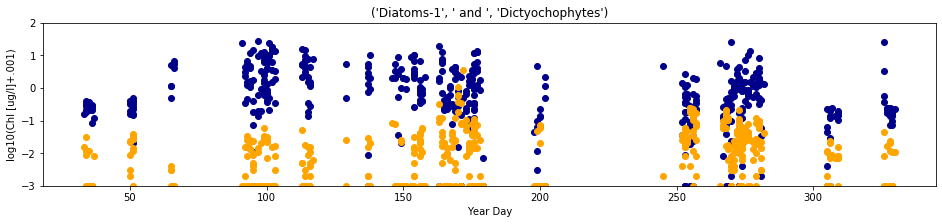

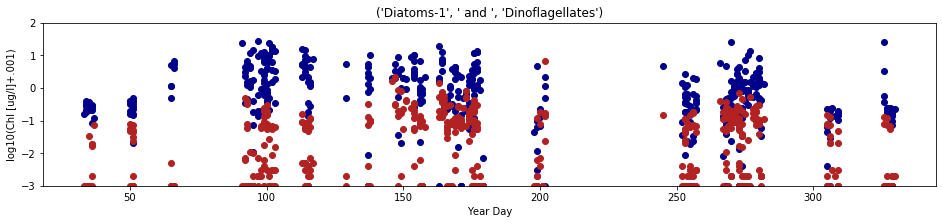

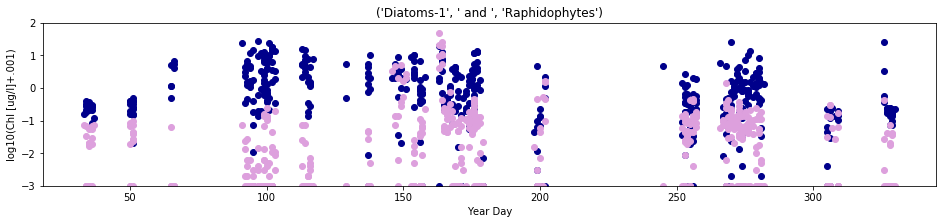

In [14]:

hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
fig,ax=plt.subplots(1,1,figsize=(16,5))
for i in range(0,len(hplclist)):
    ax.plot(data['yd'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.legend()
    ax.set_ylim(-3,2)
    ax.set_xlabel('Year Day')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(1,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.plot(data['yd'],x[:,0],'o',color=cols[0],label=hplclist[0])
    ax.plot(data['yd'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.set_ylim(-3,2)
    ax.set_title((hplclist[0],' and ',hplclist[i]))
    ax.set_xlabel('Year Day')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')

### Histogram by Year:

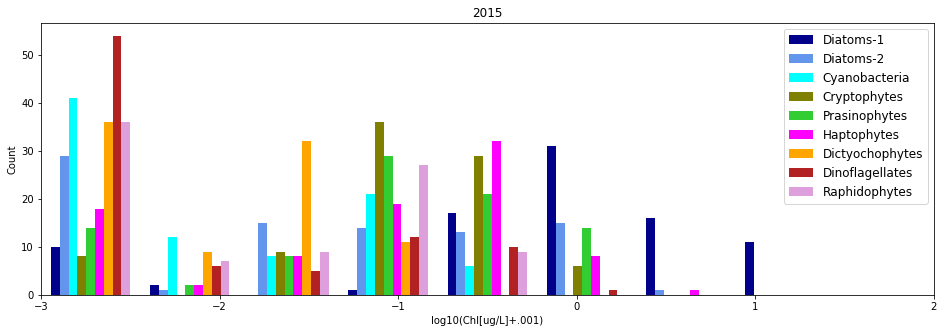

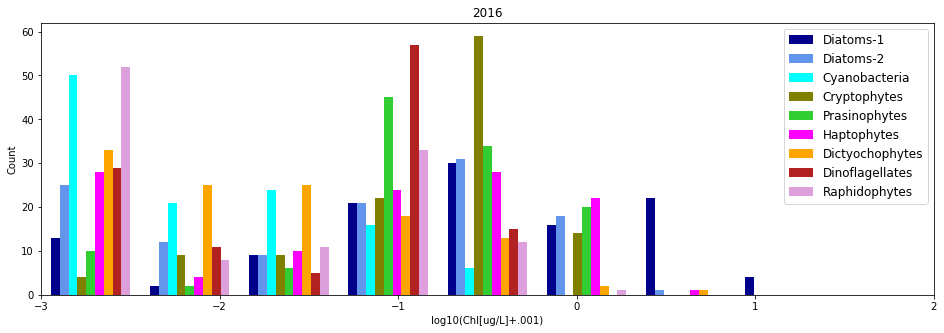

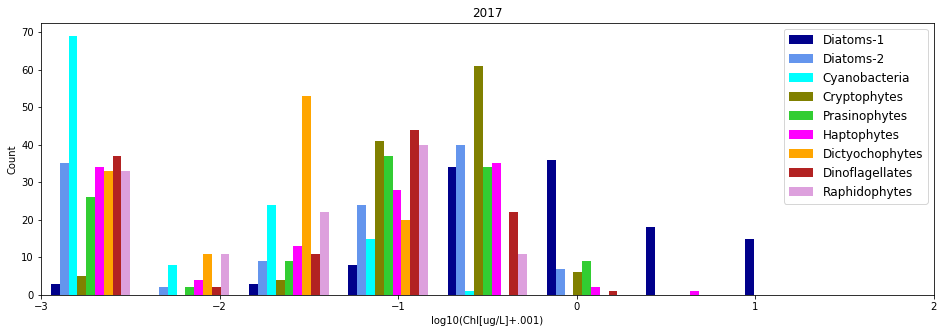

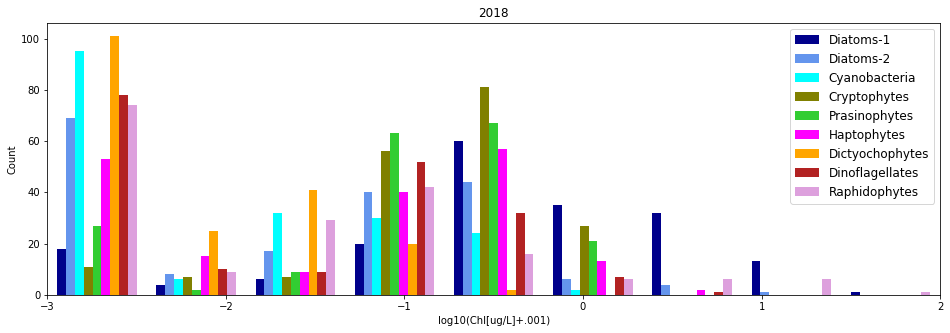

In [15]:
for year in range(2015,2019):
    fig,ax=plt.subplots(1,1,figsize=(16,5))
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(data[data.Year==year][el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    ax.legend(prop={'size': 12});
    ax.set_xlim(-3,2)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title(year)

## All Time:

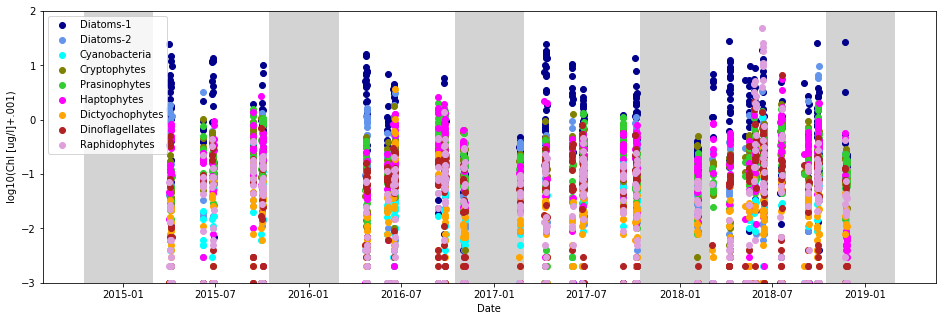

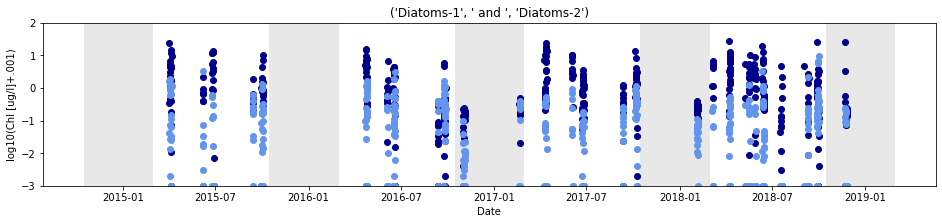

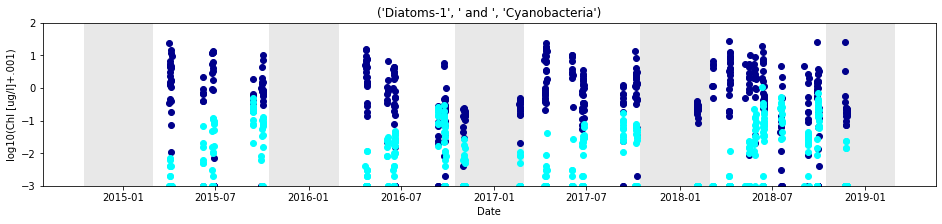

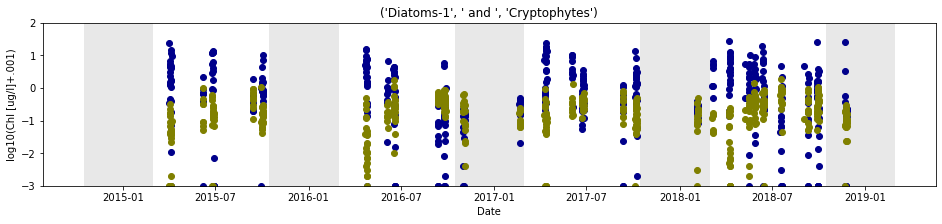

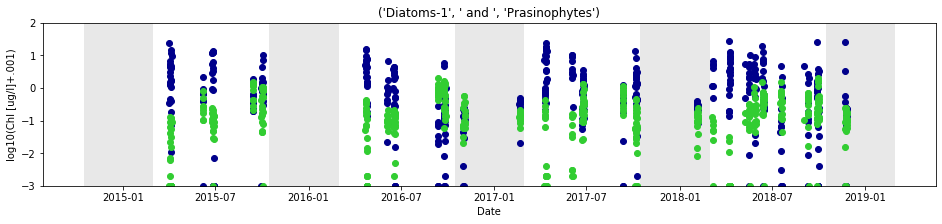

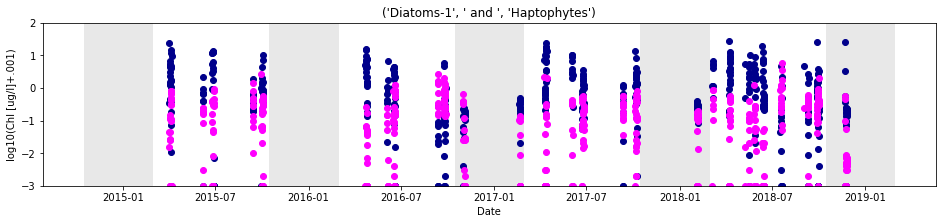

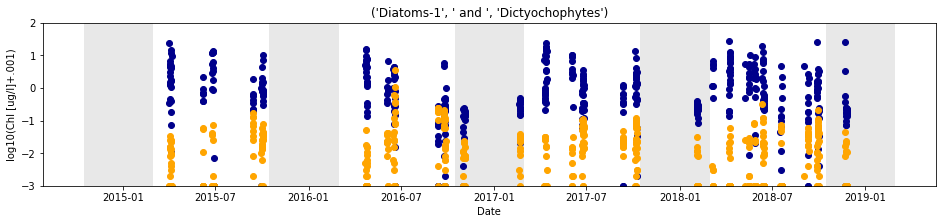

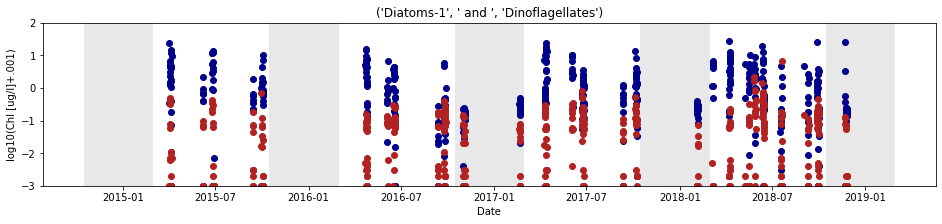

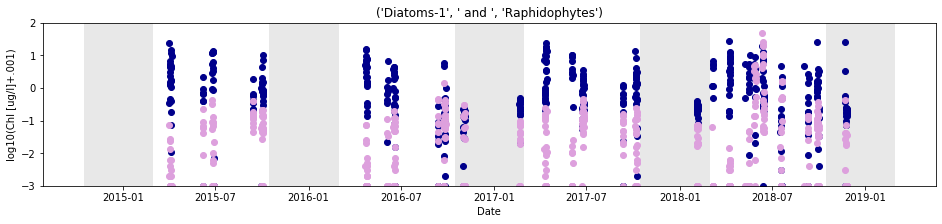

In [16]:
x=np.array([logt(data[el]) for el in hplclist]).T
fig,ax=plt.subplots(1,1,figsize=(16,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.legend()
    ax.set_ylim(-3,2)
    ax.set_xlabel('Date')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')
    for i in range(2015,2020):
        ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)
for i in range(1,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.plot(data['dtUTC'],x[:,0],'o',color=cols[0],label=hplclist[0])
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.set_ylim(-3,2)
    ax.set_title((hplclist[0],' and ',hplclist[i]))
    ax.set_xlabel('Date')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')
    for i in range(2015,2020):
        ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

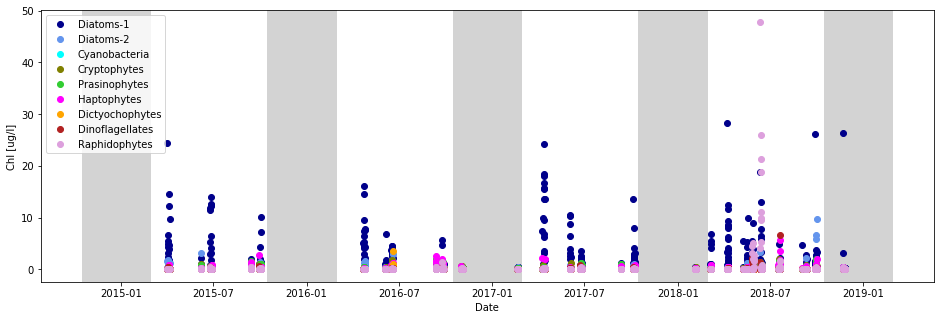

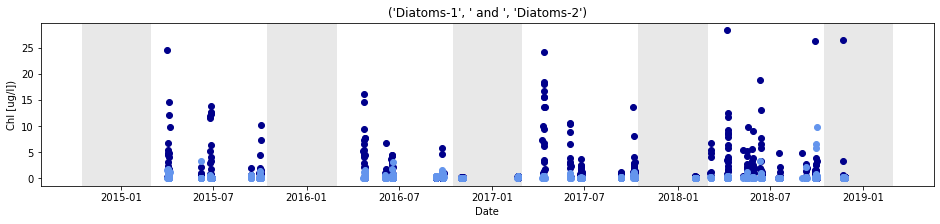

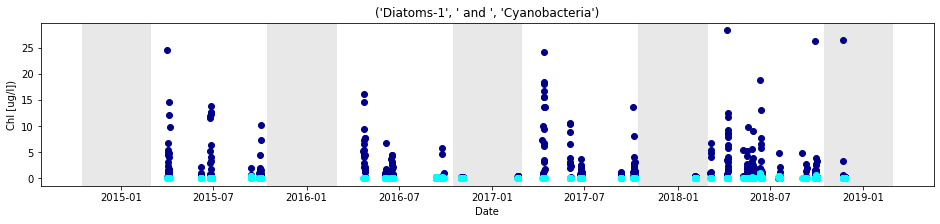

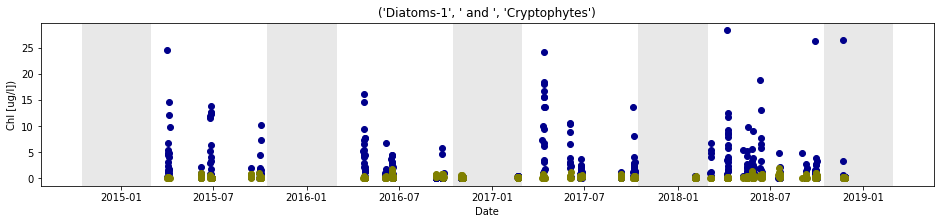

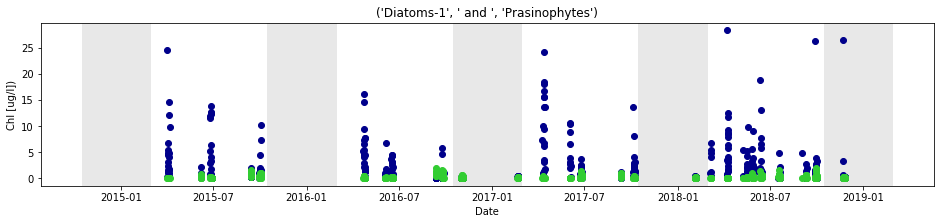

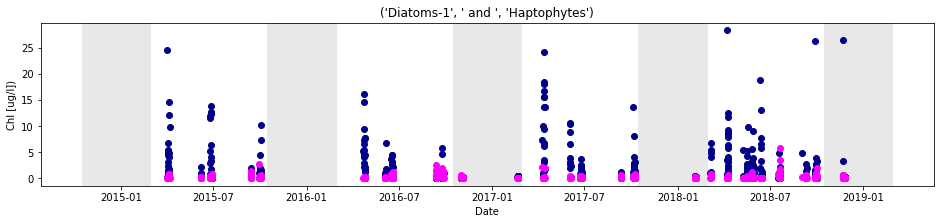

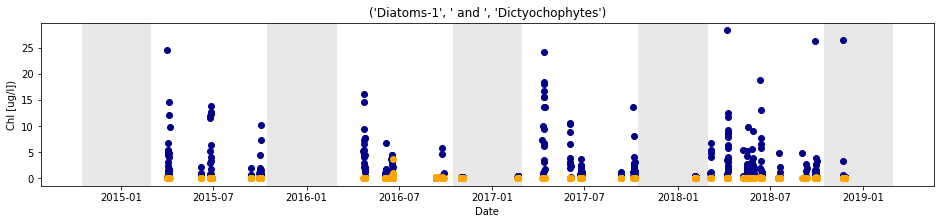

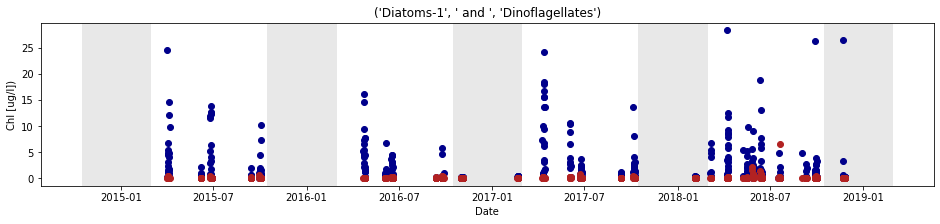

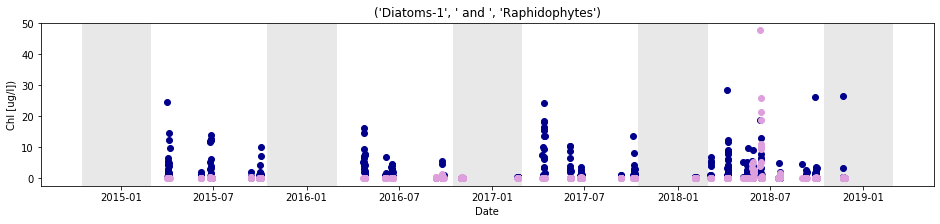

In [17]:
fig,ax=plt.subplots(1,1,figsize=(16,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],data[hplclist[i]],'o',color=cols[i],label=hplclist[i])
    ax.legend()
    #ax.set_ylim(-3,2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Chl [ug/l]')
    for i in range(2015,2020):
        ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)
for i in range(1,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.plot(data['dtUTC'],data[hplclist[0]],'o',color=cols[0],label=hplclist[0])
    ax.plot(data['dtUTC'],data[hplclist[i]],'o',color=cols[i],label=hplclist[i])
    #ax.set_ylim(-3,2)
    ax.set_title((hplclist[0],' and ',hplclist[i]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Chl [ug/l])')
    for i in range(2015,2020):
        ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

In [18]:
data['FracDiat']=data['diatoms']/(data['diatoms']+data['other'])

/home/eolson/anaconda3/envs/py38_ct/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/eolson/anaconda3/envs/py38_ct/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


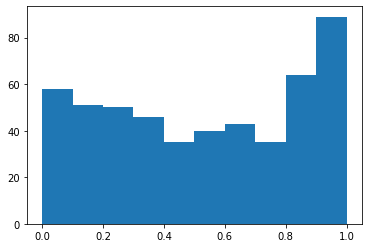

In [19]:
plt.hist(data['FracDiat']);

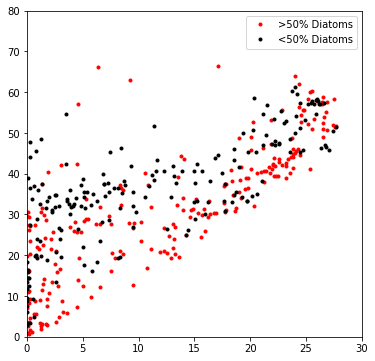

In [20]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ii=data.FracDiat>.5
ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
        data.loc[ii,['Silicate [umol/L]']],'r.',label='>50% Diatoms')
ii=data.FracDiat<.5
ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
        data.loc[ii,['Silicate [umol/L]']],'k.',label='<50% Diatoms')
ax.set_xlim(0,30)
ax.set_ylim(0,80)
ax.legend()

Text(0, 0.5, 'Si')

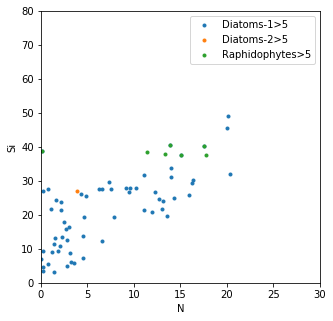

In [21]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
thresh=5
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>1:
        ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
            data.loc[ii,['Silicate [umol/L]']],'.',label=el+'>'+str(thresh))
ax.set_xlim(0,30)
ax.set_ylim(0,80)
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('Si')

Text(0, 0.5, 'Si')

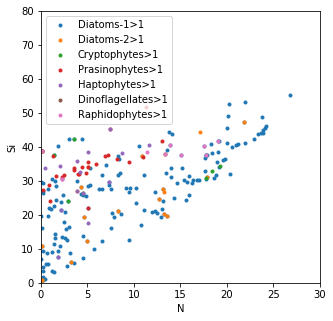

In [22]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
thresh=1
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>2:
        ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
            data.loc[ii,['Silicate [umol/L]']],'.',label=el+'>'+str(thresh))
ax.set_xlim(0,30)
ax.set_ylim(0,80)
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('Si')

Text(0, 0.5, 'P')

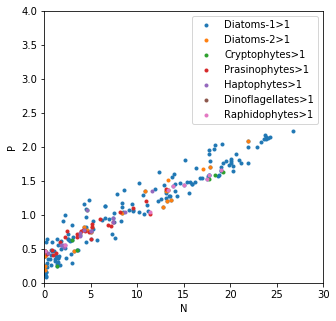

In [23]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
thresh=1
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>2:
        ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
            data.loc[ii,['Phosphate [umol/L]']],'.',label=el+'>'+str(thresh))
ax.set_xlim(0,30)
ax.set_ylim(0,4)
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('P')

Text(0, 0.5, 'Si')

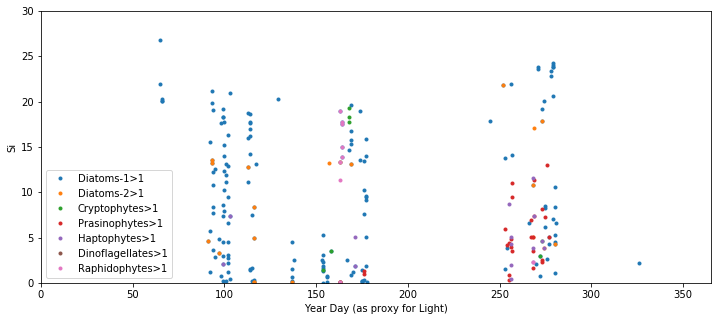

In [24]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
thresh=1
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>2:
        ax.plot(data.loc[ii,['yd']],
            data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],'.',label=el+'>'+str(thresh))
ax.set_xlim(0,365)
ax.set_ylim(0,30)
ax.legend()
ax.set_xlabel('Year Day (as proxy for Light)')
ax.set_ylabel('Si')

In [25]:
dt.datetime(2015,6,22)-dt.datetime(2015,1,1)

datetime.timedelta(days=172)

Text(0, 0.5, 'T')

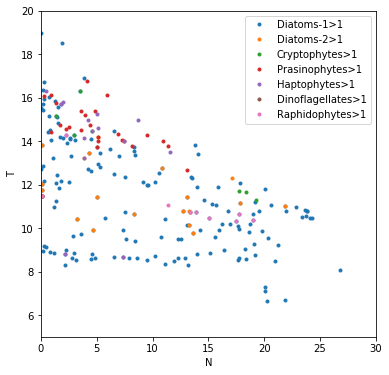

In [26]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
thresh=1
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>2:
        ax.plot(data.loc[ii,['Nitrate_plus_Nitrite [umol/L]']],
                data.loc[ii,['Temperature']],
            '.',label=el+'>'+str(thresh))
ax.set_xlim(0,30)
ax.set_ylim(5,20)
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('T')

Text(0, 0.5, 'T')

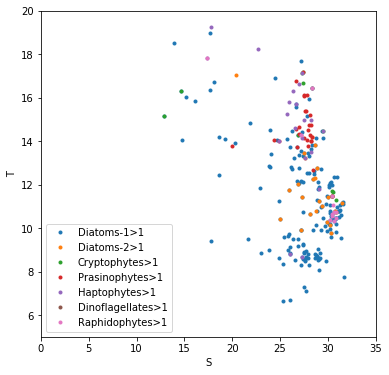

In [27]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
thresh=1
for el in hplclist:
    ii=data[el]>thresh
    if sum(ii)>2:
        ax.plot(data.loc[ii,['Salinity']],
                data.loc[ii,['Temperature']],
            '.',label=el+'>'+str(thresh))
ax.set_xlim(0,35)
ax.set_ylim(5,20)
ax.legend()
ax.set_xlabel('S')
ax.set_ylabel('T')

In [28]:
tot=0
df=pd.DataFrame(columns=('group','Percent of Total Chl'))
for el in hplclist:
    tot=tot+np.nansum(data[el])
for el in hplclist:
    df=df.append({'group':el,'Percent of Total Chl':np.nansum(data[el])/tot*100},ignore_index=True)
df.sort_values(by='Percent of Total Chl',ascending=False)

,group,Percent of Total Chl
0,Diatoms-1,58.317174
8,Raphidophytes,10.515841
3,Cryptophytes,6.742228
4,Prasinophytes,6.672676
1,Diatoms-2,6.523878
5,Haptophytes,6.483356
7,Dinoflagellates,2.687558
2,Cyanobacteria,1.107441
6,Dictyochophytes,0.949849


In [29]:
data['dtUTC'].min()

Timestamp('2015-04-01 23:42:17')

In [30]:
data['dtUTC'].max()

Timestamp('2018-11-26 01:24:02')